# Filter images

Flag which files from the metadata dataset should not be included in datasets

## Config

In [38]:
import sqlalchemy as sqa
import pandas as pd
import numpy as np
import logging
from dataclasses import dataclass, field
from typing import Set, Dict, Callable, Any, List, Optional, Tuple
import pytesseract
from collections import Counter
from functools import reduce
from tqdm.notebook import tqdm
import time
import random
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.propagate = False

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.size'] = 12
sns.set_style('whitegrid')

In [2]:
# Database parameters
db_container = "metadata_db"
db_user = "pguser"
db_password = "pgpassword"
db_port = 5432
db_database = "metadata"
db_prefix = "postgresql"
metadata_tbl = "base_images"

In [3]:
db_con_str = f"{db_prefix}://{db_user}:{db_password}@{db_container}:{db_port}/{db_database}"
db_engine = sqa.create_engine(db_con_str)

In [4]:
with db_engine.connect() as con:
    df_img = pd.read_sql_table(metadata_tbl, con, index_col="image_name")

df_img.head()

,file_name,download_loc,final_loc,full_path,search_term,source,read,orig_width,orig_height,width,height,label,label_str,download_name,filtered,filter_reason
image_name,,,,,,,,,,,,,,,,
poison_ivy_plant_1095,poison_ivy_plant_1095.jpg,simple_images/poison ivy plant/poison ivy plan...,../datasets/pipeline_v1/downloaded_images/posi...,/home/code/datasets/pipeline_v1/downloaded_ima...,poison ivy plant,Google Images,True,600,900,500,750,1,positive,poison ivy plant_1095.jpg,False,None
poison_ivy_plant_1556,poison_ivy_plant_1556.jpg,simple_images/poison ivy plant/poison ivy plan...,../datasets/pipeline_v1/downloaded_images/posi...,/home/code/datasets/pipeline_v1/downloaded_ima...,poison ivy plant,Google Images,True,713,376,713,376,1,positive,poison ivy plant_1556.jpg,False,None
poison_ivy_plant_1294,poison_ivy_plant_1294.jpg,simple_images/poison ivy plant/poison ivy plan...,../datasets/pipeline_v1/downloaded_images/posi...,/home/code/datasets/pipeline_v1/downloaded_ima...,poison ivy plant,Google Images,True,600,450,600,450,1,positive,poison ivy plant_1294.jpg,False,None
poison_ivy_plant_964,poison_ivy_plant_964.jpg,simple_images/poison ivy plant/poison ivy plan...,../datasets/pipeline_v1/downloaded_images/posi...,/home/code/datasets/pipeline_v1/downloaded_ima...,poison ivy plant,Google Images,True,750,450,750,450,1,positive,poison ivy plant_964.jpg,False,None
poison_ivy_plant_1526,poison_ivy_plant_1526.jpg,simple_images/poison ivy plant/poison ivy plan...,../datasets/pipeline_v1/downloaded_images/posi...,/home/code/datasets/pipeline_v1/downloaded_ima...,poison ivy plant,Google Images,True,822,462,822,462,1,positive,poison ivy plant_1526.jpg,False,None


## Define filters

In [5]:
@dataclass(frozen=False)
class Image_Filter:
    name: str
    filter_fn: Callable[..., bool]   # Function which takes an image (as an ndarray) and returns whether it passes filter or not
    img_names_to_check: Set[str] = field(default_factory=set)  # Which images to apply filter tp
    filter_params: Dict[str, Any] = field(default_factory=dict)
    
    def apply_filter(self, img: np.ndarray) -> bool:
        return(self.filter_fn(img, **self.filter_params))

In [6]:
# Define filter configs
google_images = set(df_img.loc[df_img['source'] == 'Google Images'].index)


def has_text_filter_fn(img: np.ndarray) -> bool:
    """
    Returns true (passes filter) pytesseract dectected text is the empty string, after stripping all whitespace
    """
    return(pytesseract.image_to_string(img, lang='eng').strip() == '')

def max_color_appearence(img: np.ndarray) -> float:
    """
    Count the fraction of pixels which make up the most common color
    Detects if there is one color appearing too much (i.e. if there is a solid background instead of a more natural looking photo)
    """
    width, height, _ = img.shape
    return(max(Counter(tuple(img[i,j,:])
                       for i in range(width)
                       for j in range(height)).values()) / (height*width))
    
    
def max_color_appearence_filter_fn(img: np.ndarray, threshold_frac: float = 0.1) -> bool:
    """
    Returns true (passes filter) if the mode color makes up less than the specified fraction of image pixels
    i.e. a failure might be an image with a solid colored background
    """
    return(max_color_appearence(img) <= threshold_frac)



# Create filter objects
has_text_filter = Image_Filter(name='Contains text',
                               filter_fn=has_text_filter_fn,
                               img_names_to_check=google_images)

max_color_filter = Image_Filter(name='Max color appearence',
                                filter_fn=max_color_appearence_filter_fn,
                                img_names_to_check=google_images,
                                filter_params={'threshold_frac': 0.1})

## Assemble Dataset Filter

In [25]:
class Image_Dataset_Filter_Group:
    """
    Runs a series of filters on an image dataset, flagging images which do not pass
    """
    def __init__(self, 
                 df_img: pd.DataFrame,
                 filters: List[Image_Filter],
                 ):
        self.df_img = df_img.copy()
        self.filters = filters
        self.img_paths_to_check = self._get_images_to_check()
    
    
    def apply_filters_to_dataset(self, with_progress: bool = True) -> pd.DataFrame:
        """
        Applies group of filters to all images based on which they are meant to check
        Returns the dataset dataframe with the filtered and filter_reason column updated
        """
        failed_imgs = self._get_failing_imgs(with_progress)
        self.df_img.loc[failed_imgs.keys(), 'filtered'] = True
        self.df_img.loc[failed_imgs.keys(), 'filter_reason'] = [*failed_imgs.values()]
        return(self.df_img)
    
    
    # HELPER METHODS
    def _get_images_to_check(self) -> Dict[str, str]:
        """
        Combine image names to check from all filters
        Store locally as dict with {image_name: image storage location}
        """
        img_names = reduce(lambda s1, s2: s1 | s2,
                           [filt.img_names_to_check for filt in self.filters],
                           set())
        # Shuffle keys so images are not ordered by which filter will be used
        img_names = random.sample([*img_names], len(img_names))
        return(self.df_img.loc[img_names, 'final_loc'].to_dict())

        
    def _apply_filters_to_img(self, img_name: str, img_path: str) -> Tuple[bool, Optional[str]]:
        """
        Apply filter group to individual image
        Return a tuple of (passed? , reason for failure or None)
        """
        for filt in self.filters:
            if img_name in filt.img_names_to_check:
                img = cv2.imread(img_path)
                assert(img is not None)
                img_passed = filt.apply_filter(img)
                if not img_passed:
                    return((False, f"Failed to pass filter: {filt.name}"))
        return((True, None)) # passed all filters
    
    
    def _get_failing_imgs(self, with_progress=True) -> Dict[str, str]:
        """
        Apply filters to all images, return dict of all failing images with {image name: reason for failure}
        """
        progress = tqdm if with_progress else lambda val: val
        failed_imgs = {}
        for img_name, img_path in progress(self.img_paths_to_check.items()):
            filter_res = self._apply_filters_to_img(img_name, img_path)
            if not filter_res[0]:
                failed_imgs[img_name] = filter_res[1]
        return(failed_imgs)
    
            
            
        

In [26]:
ds_filters = Image_Dataset_Filter_Group(df_img, [max_color_filter, has_text_filter])

In [27]:
df_img = ds_filters.apply_filters_to_dataset()

  0%|          | 0/4452 [00:00<?, ?it/s]

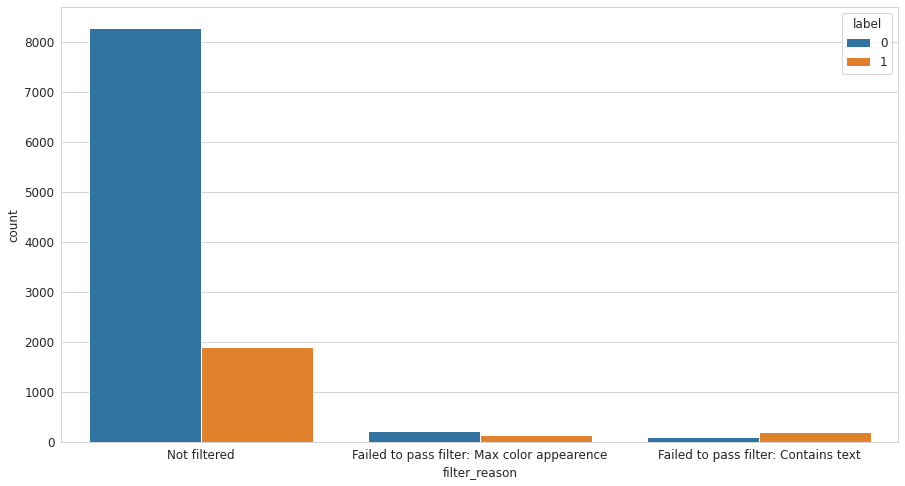

In [41]:
plt.figure(figsize=(15,8))
sns.countplot(data=df_img.fillna('Not filtered'), x='filter_reason', hue='label')
plt.show()

In [67]:
filter_reasons = df_img['filter_reason'].unique()

df_sample = df_img.copy()
df_sample['filter_reason'].fillna('Not filtered', inplace=True)
df_sample = df_sample.groupby('filter_reason').apply(lambda df: df.sample(1))
df_sample

,,file_name,download_loc,final_loc,full_path,search_term,source,read,orig_width,orig_height,width,height,label,label_str,download_name,filtered,filter_reason
filter_reason,image_name,,,,,,,,,,,,,,,,
Failed to pass filter: Contains text,Virginia_creeper_plant_225,Virginia_creeper_plant_225.jpg,simple_images/Virginia creeper plant/Virginia ...,../datasets/pipeline_v1/downloaded_images/nega...,/home/code/datasets/pipeline_v1/downloaded_ima...,Virginia creeper plant,Google Images,True,1024,576,888,500,0,negative,Virginia creeper plant_225.jpg,True,Failed to pass filter: Contains text
Failed to pass filter: Max color appearence,Poison_sumac_plant_172,Poison_sumac_plant_172.jpg,simple_images/Poison sumac plant/Poison sumac ...,../datasets/pipeline_v1/downloaded_images/nega...,/home/code/datasets/pipeline_v1/downloaded_ima...,Poison sumac plant,Google Images,True,807,1200,500,743,0,negative,Poison sumac plant_172.jpg,True,Failed to pass filter: Max color appearence
Not filtered,Fragrant_sumac_plant_30,Fragrant_sumac_plant_30.jpg,simple_images/Fragrant sumac plant/Fragrant su...,../datasets/pipeline_v1/downloaded_images/nega...,/home/code/datasets/pipeline_v1/downloaded_ima...,Fragrant sumac plant,Google Images,True,1000,669,747,500,0,negative,Fragrant sumac plant_30.jpg,False,Not filtered


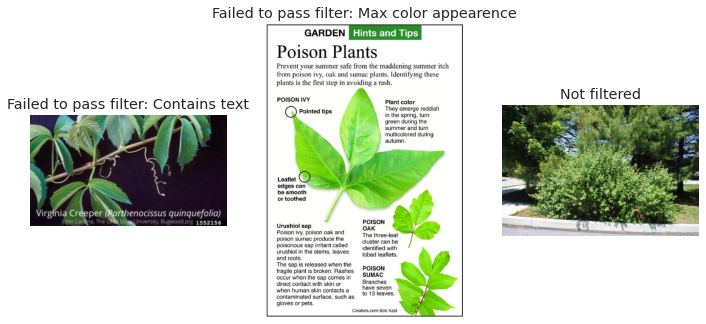

In [68]:
n_ims = len(df_sample.index)
plt.figure(figsize=(12,6))
for i, img_name in enumerate(df_sample.index):
    ax = plt.subplot(1, n_ims, i + 1)
    plt.imshow(plt.imread(df_sample.at[img_name, 'final_loc']))
    plt.title(df_sample.at[img_name, 'filter_reason'])
    plt.axis("off")

## Update in the metadata db

In [56]:
df_filt = df_img[df_img['filtered'] == True]

def update_query(img_name: str, filter_reason: str):
    return(f"""
           UPDATE {metadata_tbl}
           SET filtered = TRUE, filter_reason = '{filter_reason}'
           WHERE image_name = '{img_name.replace("'", "''")}'
           """)

In [57]:
with db_engine.connect() as con:
    for img_name, filter_reason in tqdm(zip(df_filt.index, df_filt['filter_reason']),
                                        total=len(df_filt.index)):
        con.execute(update_query(img_name, filter_reason))

  0%|          | 0/641 [00:00<?, ?it/s]